# 프로젝트 : 폐렴 진단기 성능개선

- LMS에서 대략 80% 정도의 정확도를 보여준 X-RAY 사진 판독 폐렴 사진기를 만들어 보았다.
- 숙련된 의사들은 90% 이상의 정확도를 보인다고 한다.
- 이전의 실습과정을 되짚어보며 개선할 부분을 찾아보고 성능 향상을 시도해 보자.


## Step 1. 실험환경 Set-up

### 데이터셋
___

- 데이터 : **캐글의 Chest X-Ray Images**

- 데이터 구성 : `~/aiffel/chest_xray/data` 하위에 3개의 폴더 (train, test, val)로 구성
    - 각 이미지 카테고리 (폐렴 / 정상)에 대한 하위 폴더를 포함
    - 5,856 개의 X-Ray 이미지 (JPEG)와 2 개의 범주 (폐렴 / 정상)가 있다.
    - 이미지는 중국 광저우 여성 및 어린이 병원의 1~5 세 소아 환자의 흉부 X선 영상 



- 패키지 load

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

print('Tensorflow version : {}'.format(tf.__version__))

Init Plugin
Init Graph Optimizer
Init Kernel
Tensorflow version : 2.5.0


- 필요한 변수 생성

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 아래 두 변수는 하이퍼 파라미터
BATCH_SIZE = 32
EPOCHS = 25

print(ROOT_PATH)
print(TRAIN_PATH)

/Users/castlemoney/aiffel
/Users/castlemoney/aiffel/chest_xray/data/train/*/*


## Step 2. 데이터 준비하기

- 아래 그림과 같은 구조의 디렉토리에 **train, val(validation), test** 로 나누어져 있다.
- 각 데이터들의 개수를 확인해보자.

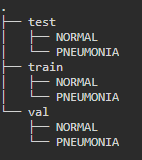


- [tf.io.gfile.glob](https://www.tensorflow.org/api_docs/python/tf/io/gfile/glob#used-in-the-notebooks) : 주어진 패턴과 목록을 반환

In [3]:
# 각각의 파일 목록이 list로 저장됨
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

# list 형태로 저장된 변수에서 각각 파일의 개수 확인
print('train 데이터 : ', len(train_filenames), '개')
print('test  데이터 : ', len(test_filenames), '개')
print('val   데이터 : ', len(val_filenames), '개')

# 참고용
val_filenames

train 데이터 :  5216 개
test  데이터 :  624 개
val   데이터 :  16 개


['/Users/castlemoney/aiffel/chest_xray/data/val/PNEUMONIA/person1950_bacteria_4881.jpeg',
 '/Users/castlemoney/aiffel/chest_xray/data/val/PNEUMONIA/person1951_bacteria_4882.jpeg',
 '/Users/castlemoney/aiffel/chest_xray/data/val/PNEUMONIA/person1952_bacteria_4883.jpeg',
 '/Users/castlemoney/aiffel/chest_xray/data/val/PNEUMONIA/person1946_bacteria_4874.jpeg',
 '/Users/castlemoney/aiffel/chest_xray/data/val/PNEUMONIA/person1947_bacteria_4876.jpeg',
 '/Users/castlemoney/aiffel/chest_xray/data/val/PNEUMONIA/person1946_bacteria_4875.jpeg',
 '/Users/castlemoney/aiffel/chest_xray/data/val/PNEUMONIA/person1949_bacteria_4880.jpeg',
 '/Users/castlemoney/aiffel/chest_xray/data/val/PNEUMONIA/person1954_bacteria_4886.jpeg',
 '/Users/castlemoney/aiffel/chest_xray/data/val/NORMAL/NORMAL2-IM-1440-0001.jpeg',
 '/Users/castlemoney/aiffel/chest_xray/data/val/NORMAL/NORMAL2-IM-1437-0001.jpeg',
 '/Users/castlemoney/aiffel/chest_xray/data/val/NORMAL/NORMAL2-IM-1431-0001.jpeg',
 '/Users/castlemoney/aiffel/che

- 각각의 비율 : train(89%), test(10.7%), val(0.3%)
- val 데이터 매우 적다. 
- train에서 val에 쓰일 데이터를 가져오자.

- [math.floor()](https://ooyoung.tistory.com/99) : 실수를 내림하여 정수 반환하는 함수

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8) # 실수를 내림하여 정수 반환
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print('train 데이터 : ', len(train_filenames), '개')
print('val   데이터 : ', len(val_filenames), '개')

train 데이터 :  4185 개
val   데이터 :  1047 개


- 최종 데이터
    - train : 4185개
    - test  :  624개
    - val   : 1047개

<br>

- train 데이터 안에 정상 이미지 수와 폐렴 이미지 수를 확인해 보자.

In [5]:
print(f'1. Normal image path\n{filenames[0]}\n')
print(f'2. Pneumonia image path\n{filenames[2000]}')

1. Normal image path
/Users/castlemoney/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0561-0001.jpeg

2. Pneumonia image path
/Users/castlemoney/aiffel/chest_xray/data/train/PNEUMONIA/person326_bacteria_1505.jpeg


<br>

- 위의 파일 경로로 정상(NORMAL)/폐렴(PNUMMONIA) 구분 가능


In [6]:
# 파일 경로에 "NORMAL" 문자열 확인하여 정상 이미지 개수 확인
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 "PNEUMONIA" 문자열 확인하여 정상 이미지 개수 확인
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


- 정상보다 폐렴 이미지 수가 3배 더 많이 있다.
- CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 한다.
- 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정
- test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로
- imbalance한 데이터 셋이어도 문제가 없다.


- [tf.data.Dataset API](https://m.blog.naver.com/euue717/222086046496)
- tf.data 인스턴스를 만들어 보자.
- tf.data는 tensorflow에서 학습시킬 때, **mini-batch**로 작업할 수 있도록 해 준다.

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

# tf.data 인스턴스 내용 확인 참고용
print(val_list_ds, '\n')
print(len(val_list_ds), '\n')

n = 0
for i in val_list_ds:
    print(i)
    n += 1
    if n == 2:
        break

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

<TensorSliceDataset shapes: (), types: tf.string> 

1047 

tf.Tensor(b'/Users/castlemoney/aiffel/chest_xray/data/train/NORMAL/IM-0486-0001.jpeg', shape=(), dtype=string)
tf.Tensor(b'/Users/castlemoney/aiffel/chest_xray/data/train/PNEUMONIA/person444_bacteria_1927.jpeg', shape=(), dtype=string)


2022-02-09 21:31:17.554566: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-09 21:31:17.554667: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


- [tf.data.experimental.cardinality](https://www.tensorflow.org/api_docs/python/tf/data/experimental/cardinality)
- Train, validation 데이터셋 개수 다시 확인 해보자.

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


- 현재 이미지에는 라벨 데이터가 따로 없다.
- 파일 경로 포함된 'NORMAL', 'PNEUMONIA'를 이용해서 라벨 데이터를 만들어 주는 함수를 정의해 보자.

In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

- 이미지 데이터는 사이즈가 제각각일 가능성이 높다.
- 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여보자.
- `process_path` 함수에서 `decode_img` 함수를 이용
- 이미지 데이터 타입 float으로 바꾸고 사이즈 변경
- get_label을 이용해서 라벨 값을 가져온다.

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE(180X180)로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

- train, validation 데이터 셋을 만들자.
- num_parallel_calls 파라미터에 변수 생성단계에서 할당한 AUTOTUNE 변수를 이용
- 더욱 빠르게 데이터를 처리할 수 있다.

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

- 이미지 리사이즈, 라벨이 잘 들어갔는지 확인해 보자.
- train_ds.take(1) : 전체 train 데이터셋 중 하나의 데이터만을 가져온다.

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


2022-02-09 21:31:17.655351: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-09 21:31:17.655777: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


- 위의 방법으로 test 데이터셋도 만들고 데이터 개수도 확인해보자.

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


- Tensorflow에서는 **tf.data 파이프라인**을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해준다.
- tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의하고 데이터를 변환시켜주자.


- `shuffle()` : 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택한다.

- `repeat()` : 여러 번 데이터셋을 사용할 수 있게 해준다.
    - 예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요한데 
    - repeat()를 사용하면 자동으로 데이터를 맞춰준다.

- `batch()` : BATCH_SIZE에서 정한 만큼의 배치로 주어진다.
    - 예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 된다.

- `prefetch()` : 학습 데이터를 나눠서 읽어돈다.
    - 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어
    - 리소스의 유휴 상태를 줄일 수 있다.

In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## Step 3. 데이터 시각화

- train에 있는 batch 중 첫 번째 배치 추출
- 추출된 배치를 image와 label 데이터 셋으로 나눈다.
- show_batch() 함수를 이용해서 결과를 확인해보자.


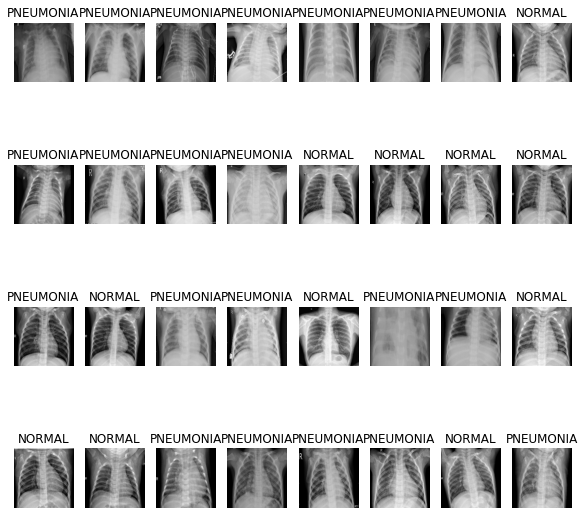

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))  
    for n in range(BATCH_SIZE):  # BATCH_SIZE 만큼의 이미지 출력
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## Step 4. CNN 모델링

- 이미지 처리에 특화된 CNN을 통해 모델링을 하고 결과를 만들어 보자.
- Convolution block 구성
    - Convolution을 두 번 진행
    - Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결
    - Max Pooling을 한다.
- Dense block 

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

- 위 모델은 Batch Normalization과 Dropout 두 가지 regularization 기법이 동시에 사용되고 있다.
- 일반적으로 이런 방법은 잘 사용되지 않거나, 금기시되기도 한다.
    - 대표적인 논문 사례
        - [Understanding the Disharmony between Dropout and Batch Normalization by Variance Shift](https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf)

- 실용적으로는 두 방법을 같이 사용하는 것이 낫다고 보는 견해도 있다.
    - 예외적으로 동시에 사용하는 것이 성능 향상에 도움을 주는 사례
        - [Rethinking the Usage of Batch Normalization and Dropout in the Training of Deep Neural Networks](https://arxiv.org/pdf/1905.05928.pdf)

- 이 두 가지를 함께 사용하는 이 모델이 성능 향상에 도움이 될지 여부도 흥미롭게 다가오는 부분이다.

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## Step 5. 데이터 imbalance 처리

- Step 2.에서 class가 불균형(imbalance)한 데이터에 대해 차후에 조정한다고 했었다.
- 이 문제를 해결하는 방법으로 `Weight balancing`이라는 테크닉이 사용된다.
    - Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때  
    - 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법  
    
- Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 
- 클래스별 가중치를 세팅할 수 있도록 지원하고 있다. 
- [상세 내용 : 딥러닝에서 클래스 불균형을 다루는 방법](https://3months.tistory.com/414)


- `weight_for_0`은 'Normal' 이미지에 사용할 weight 세팅
- `weight_for_1`은 'Pneumonia' 이미지에 사용할 weight 세팅
- 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정된다.

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## Step 6. 모델 훈련

- 이미지 훈련은 GPU를 사용
- 모델은 위에서 만든 함수 build_model()을 model에 선언
- 이미지의 라벨이 두 개이기에 "binary_cross entropy" loss 사용
- optimizer로 'adam'을 사용
- 성과 측정 metrics : 'accuracy', 'precision', 'recall' 사용

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

- 이제 모델을 fit 해보자.
- 위에서 선언했었던 변수, 데이터 셋을 각 파라미터에 맞게 넣어주자.

In [21]:
with tf.device('/GPU:0'):
   
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight
    )

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/25


2022-02-09 21:31:20.714559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


130/130 [==============================] - ETA: 0s - loss: 0.3918 - accuracy: 0.8161 - precision: 0.9460 - recall: 0.7984

2022-02-09 21:31:36.974665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


130/130 [==============================] - 20s 133ms/step - loss: 0.3918 - accuracy: 0.8161 - precision: 0.9460 - recall: 0.7984 - val_loss: 0.6137 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 2/25
130/130 [==============================] - 17s 132ms/step - loss: 0.2019 - accuracy: 0.9212 - precision: 0.9792 - recall: 0.9135 - val_loss: 0.6128 - val_accuracy: 0.7314 - val_precision: 0.7314 - val_recall: 1.0000
Epoch 3/25
130/130 [==============================] - 17s 132ms/step - loss: 0.1673 - accuracy: 0.9344 - precision: 0.9792 - recall: 0.9313 - val_loss: 0.6769 - val_accuracy: 0.7314 - val_precision: 0.7314 - val_recall: 1.0000
Epoch 4/25
130/130 [==============================] - 17s 134ms/step - loss: 0.1293 - accuracy: 0.9478 - precision: 0.9858 - recall: 0.9435 - val_loss: 0.8642 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 5/25
130/130 [==============================] - 18s 136ms/step - loss: 0.1360 - accuracy: 0.9457 

## Step 7. 결과 확인과 시각화

- 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 확인해보자.

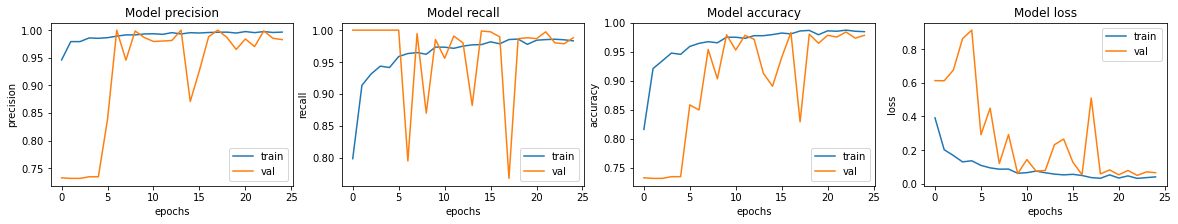

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

- 테스트 데이터로 모델 평가를 해보자.
- 모델 평가를 위해 loss, accuracy, precision, recall 값을 출력해 보자.
- train accuracy는 약 96% 이상 정확도를 보여주고 있으나
- test 데이터로 확인 결과는 약 72% 정도의 정확도를 보여주었다.
- train 과는 20% 이상의 차이를 보여주고 있다. 이것은 과적합에 의한 차이로 밖에는 생각되지 않는다.

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 1s 45ms/step - loss: 0.9818 - accuracy: 0.7212 - precision: 0.6915 - recall: 1.0000
Loss: 0.9818087220191956,
Accuracy: 0.7211538553237915,
Precision: 0.6914893984794617,
Recall: 1.0


## Step 8. Finetune the model

- 아래에서는 테스트 성능 향상을 위해서 `Finetuning`을 해보자.
- [참고. TensorFlow Pneumonia Classification on X-rays](https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays)

###  1. keras callbacks 사용 
- ModelCheckpoint : 모델의 가장 좋은 가중치 저장
- EarlyStopping   : 모델이 정체되거나 과적합되기 시작할 때 훈련 프로세스 중지
    - `restore_best_weights=True`
    - 훈련 과정이 끝날 때 반환된 모델은 최고의 가중치를 가진 모델이 된다.(즉, 낮은 손실과 높은 정확도)


In [24]:
cb = tf.keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)
es = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

### 2. learning rate 조정
- 학습률이 너무 높으면 모델이 발산한다.
- 학습률이 너무 작으면 모델이 너무 느려진다.
- 아래의 지수 학습률 스케줄링 방법을 구현해보자.

In [25]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [26]:
with tf.device('/GPU:0'):
    
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[cb, es, lr_scheduler]
    )

Epoch 1/25
130/130 [==============================] - 19s 132ms/step - loss: 0.3011 - accuracy: 0.8832 - precision: 0.9503 - recall: 0.8895 - val_loss: 0.6094 - val_accuracy: 0.8574 - val_precision: 0.8420 - val_recall: 0.9906
Epoch 2/25
130/130 [==============================] - 17s 133ms/step - loss: 0.1849 - accuracy: 0.9281 - precision: 0.9759 - recall: 0.9265 - val_loss: 0.5274 - val_accuracy: 0.7812 - val_precision: 0.7698 - val_recall: 1.0000
Epoch 3/25
130/130 [==============================] - 17s 133ms/step - loss: 0.1641 - accuracy: 0.9418 - precision: 0.9775 - recall: 0.9433 - val_loss: 1.0016 - val_accuracy: 0.6182 - val_precision: 1.0000 - val_recall: 0.4787
Epoch 4/25
130/130 [==============================] - 17s 133ms/step - loss: 0.1525 - accuracy: 0.9397 - precision: 0.9801 - recall: 0.9381 - val_loss: 0.5982 - val_accuracy: 0.7842 - val_precision: 0.7743 - val_recall: 0.9960
Epoch 5/25
130/130 [==============================] - 17s 132ms/step - loss: 0.1382 - accura

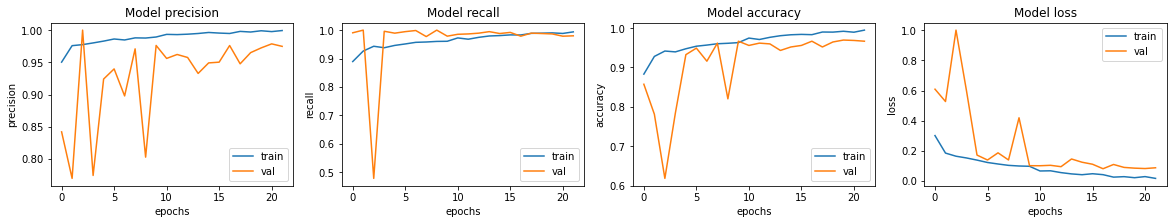

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [28]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 1s 42ms/step - loss: 0.6315 - accuracy: 0.7981 - precision: 0.7588 - recall: 0.9923
Loss: 0.6315189599990845,
Accuracy: 0.7980769276618958,
Precision: 0.758823573589325,
Recall: 0.992307722568512


### Finefune 후 
- Finetune 이전 학습과 비슷하게 약 96% 이상의 정확도를 보여주고 있다.
- test 데이터로 확인 결과는 약 79%의 정확도로 7% 정도 향상되었지만 의미있는 향상이라고 보기는 어렵다고 판단된다.
- 여전히 train 대비 약 20% 가량의 차이를 보여주고 있다. 또한 여전히 과적합이 되고 있다고 생각된다.

- 저장된 "best-model.h5"로 결과 예측과 평가해보자.

In [29]:
best_model = tf.keras.models.load_model('best-model.h5')

loss, accuracy, precision, recall = best_model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

2022-02-09 21:44:55.584907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 45ms/step - loss: 0.6315 - accuracy: 0.7981 - precision: 0.7588 - recall: 0.9923
Loss: 0.6315190196037292,
Accuracy: 0.7980769276618958,
Precision: 0.758823573589325,
Recall: 0.992307722568512


- "best-model" 사용 후에도 위에서 확인한 내용과 똑같이 나왔다.
- 이것은 "best-model"의 저장 시점이 epochs 최종시점에 저장된 모델이라서 그런 것으로 판단된다.


### 3. 데이터 좌우 반전 augmentation 시도 

- 위에서 시도했던 방법 그대로 좌우 반전 augmentation 만 추가하여 시도해 보자.

In [30]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

print('Tensorflow version : {}'.format(tf.__version__))

Tensorflow version : 2.5.0


In [31]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 아래 두 변수는 하이퍼 파라미터
BATCH_SIZE = 32
EPOCHS = 25

print(ROOT_PATH)
print(TRAIN_PATH)

/Users/castlemoney/aiffel
/Users/castlemoney/aiffel/chest_xray/data/train/*/*


In [32]:
# 각각의 파일 목록이 list로 저장됨
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

# list 형태로 저장된 변수에서 각각 파일의 개수 확인
print('train 데이터 : ', len(train_filenames), '개')
print('test  데이터 : ', len(test_filenames), '개')
print('val   데이터 : ', len(val_filenames), '개')

train 데이터 :  5216 개
test  데이터 :  624 개
val   데이터 :  16 개


In [33]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8) # 실수를 내림하여 정수 반환
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print('train 데이터 : ', len(train_filenames), '개')
print('val   데이터 : ', len(val_filenames), '개')

train 데이터 :  4185 개
val   데이터 :  1047 개


In [34]:
print(f'1. Normal image path\n{filenames[0]}\n')
print(f'2. Pneumonia image path\n{filenames[2000]}')

1. Normal image path
/Users/castlemoney/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0561-0001.jpeg

2. Pneumonia image path
/Users/castlemoney/aiffel/chest_xray/data/train/PNEUMONIA/person326_bacteria_1505.jpeg


In [35]:
# 파일 경로에 "NORMAL" 문자열 확인하여 정상 이미지 개수 확인
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 "PNEUMONIA" 문자열 확인하여 정상 이미지 개수 확인
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [36]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [37]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [38]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [39]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE(180X180)로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [40]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [41]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [42]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_au = prepare_for_training(train_ds)
val_ds_au = prepare_for_training(val_ds)

In [43]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


- 좌우 반전 이미지 확인

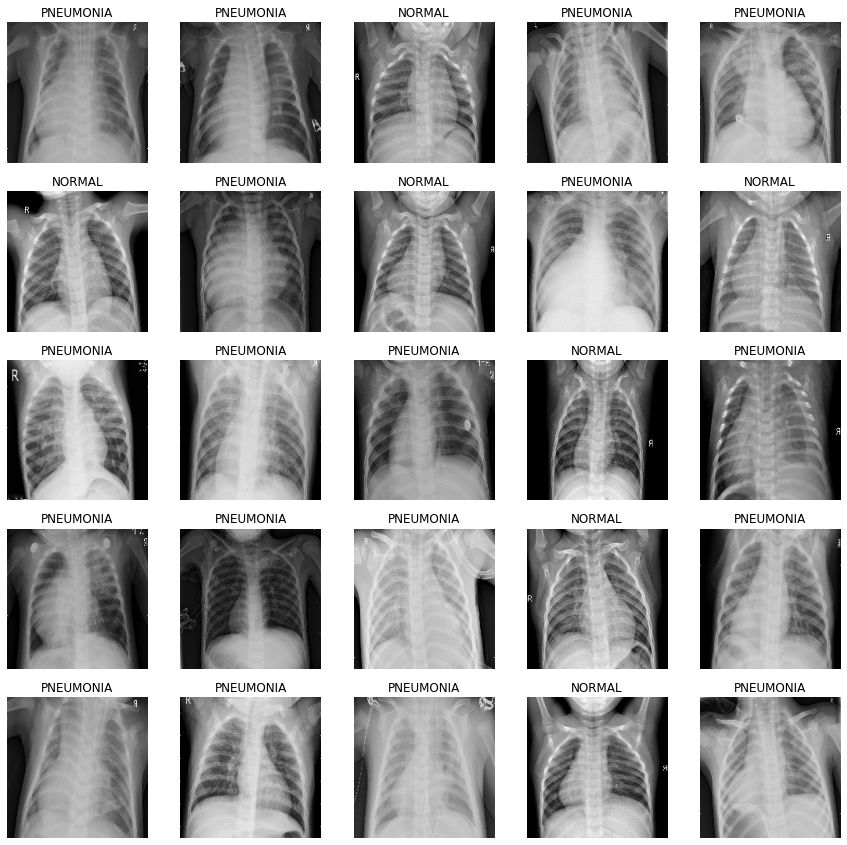

In [44]:
image_batch_au, label_batch_au = next(iter(train_ds_au))

def show_batch_au(image_batch, label_batch):
    plt.figure(figsize=(15,15))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch_au[n])
        if label_batch_au[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch_au(image_batch_au.numpy(), label_batch_au.numpy())

In [45]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [46]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [47]:
def build_model_au():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [48]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [49]:
with tf.device('/GPU:0'):
    model_au = build_model_au()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_au.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [50]:
with tf.device('/GPU:0'):
   
    history_au = model_au.fit(
        train_ds_au,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_au,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight
    )

Epoch 1/25


2022-02-09 21:45:00.513814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


130/130 [==============================] - ETA: 0s - loss: 0.4162 - accuracy: 0.8048 - precision: 0.9471 - recall: 0.7812

2022-02-09 21:45:16.610797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


130/130 [==============================] - 20s 134ms/step - loss: 0.4162 - accuracy: 0.8048 - precision: 0.9471 - recall: 0.7812 - val_loss: 0.6034 - val_accuracy: 0.7383 - val_precision: 0.7383 - val_recall: 1.0000
Epoch 2/25
130/130 [==============================] - 17s 131ms/step - loss: 0.1979 - accuracy: 0.9255 - precision: 0.9797 - recall: 0.9190 - val_loss: 0.5907 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 3/25
130/130 [==============================] - 17s 132ms/step - loss: 0.1584 - accuracy: 0.9394 - precision: 0.9844 - recall: 0.9335 - val_loss: 0.7266 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 4/25
130/130 [==============================] - 17s 133ms/step - loss: 0.1479 - accuracy: 0.9440 - precision: 0.9818 - recall: 0.9421 - val_loss: 0.8291 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 5/25
130/130 [==============================] - 17s 133ms/step - loss: 0.1270 - accuracy: 0.9522 

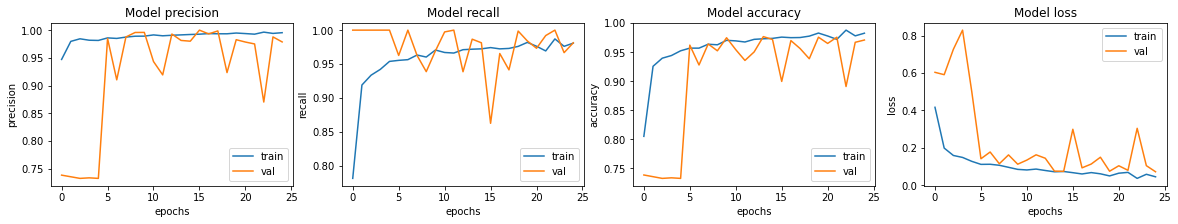

In [51]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_au.history[met])
    ax[i].plot(history_au.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [52]:
loss, accuracy, precision, recall = model_au.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 1s 45ms/step - loss: 0.8776 - accuracy: 0.7308 - precision: 0.6996 - recall: 0.9974
Loss: 0.877638041973114,
Accuracy: 0.7307692170143127,
Precision: 0.6996402740478516,
Recall: 0.9974359273910522


- 좌우반전 augmentation 적용하여 시도해 보았다.
- 여전히 초기 학습시의 정확도와 크게 다르지 않은 결과를 보여주고 있다.

## 회고


### 1. 시도해 본 것
- epochs : 10 ~ 50 까지 다양하게 시도
    - 가장 적절하다고 판단된 회수 : 20~25회
- BATCH_SIZE : 8, 16, 32, 64
    - 가장 적합하다고 판단된 size : 32
- BatchNormalization 과 dropout 적용 방법 변경
    - BatchNormalization과 dropout 각각 적용해 보았지만 동시 적용하는 방법이 정확도가 더 좋았다.
- callbacks, learning rate scheduler 적용
    - 적용 전보다 적용 후가 더 좋은 정확도로 향상되는 것을 확인 할 수 있었다.
    - 하지만 유의미하게 해석해도 될 지 의문을 가질 정도의 향상있었다.
    - 실무에서는 어떻게 판단할 지 궁금하기도 하다.


### 2. 아쉬움이 남는 것

- 모델 정의시 layer 추가, BatchNormalization 적용 위치 변경에 따른 변화 확인
- tf.data 파이프라인 shuffle 적용시 random_seed 고정에 따른 변화 확인
- 과적합이 되는 현상이 지속적으로 나오기에 dropout 비율을 증가하여 적용시 변화 확인

### 3. 최종 정리
- 여러가지 시도를 해보았지만 루브릭에서 요구한 정확도를 확인하긴 어려웠다.
- 이것은 데이터의 양이 너무 적었기에 어쩔수 없는 현상이라고 판단된다.
- 또 의학적인 검증 능력없이 무턱대고 데이터 증강을 사용할 수도 없다고 생각했다.
- 때로는 정확도가 85% 이상으로 나오는 경우도 10번에 1번 정도는 되었던 것 같다.
- 이것은 데이터가 랜덤하게 섞이는 과정에서 어쩌다 나오게 되는 현상이라고 밖엔 생각되지 않았다.
- 이런 현상이 나오는 시점의 학습데이터 모델을 저장하여 사용하면 되겠다는 생각도 들었다. 이것이 올바른 방향 생각인지는 의문이다.
- 여러가지 생각이 교차하지만 여기서 본 프로젝트를 종료하고자 한다.

In [53]:
tf.random.set_seed(15)  # 전역 랜덤 seed